# Step 0: Imports

Question: 

- Do the attention heads learn to attend to the same positional encodings
- do interp -- what is it doing? can we figure out?
- update: I think we should do interp once it's bigger. 

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from math import sqrt
from collections import deque
import os
import random
from concurrent.futures import ProcessPoolExecutor
import pickle

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 15
MAX_TUNE_VTXS = 7
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
EPOCH_SIZE = 2**20
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [3]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [min(u,v),max(u,v)]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

# input: G, represented as an adjacency list
# output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
# if target is set to some value, then we instead just output that specific distance
def SSSP(G, target=2):
    dist = [MAX_VTXS for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def mkbatch(size):
    graphs1 = []
    distance1 = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS)
        edge_list, adj_list = random_graph(n)
        dist = SSSP(adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)
    
    data = torch.tensor(graphs1)
    labels = torch.tensor(distance1, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

def savebatch(size, idx):
    data, labels, padding = mkbatch(size)
    everything = {
        "data": data,
        "labels": labels,
        "padding": padding,
    }
    
    with open(f'data31/{idx}.pickle', 'wb') as file:
        pickle.dump(everything, file)

def vertices_on_shortest_12_path(G, target=2):
    dist = [MAX_VTXS for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

def mktunebatch(size, test=False):
    graphs = []
    distance = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS if test else MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                if target_vtx > MAX_TUNE_VTXS:
                    continue
                edge_list[-1] = target_vtx
                graphs.append(edge_list)
                distance.append(target_vtx_idx)
                break
    
    data = torch.tensor(graphs)
    labels = torch.tensor(distance, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

In [4]:
# Only need to run this once to generate training data
# RESTART THE KERNEL BEFORE RUNNING AND ONLY RUN THE CELLS ABOVE
# Python is slow and awful

# with ProcessPoolExecutor() as executor:
#     for i in range(1000):
#         executor.submit(savebatch, EPOCH_SIZE, i)
#     executor.shutdown()

In [5]:
mkbatch(5)

(tensor([[ 1,  2,  5, 12,  3, 12,  2, 11,  9, 12,  2, 10,  1,  7,  1,  2,  9, 10,
           1,  9,  4, 12,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 9, 12,  4,  7,  8, 10,  5, 13,  1, 13,  3, 13,  7, 12,  5,  6,  3,  4,
           6, 13,  2,  7,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 1,  5,  8, 12,  2,  9,  2,  7,  5,  9, 10, 11,  6, 10,  4, 12,  1,  2,
           4, 11,  2,  5,  2,  4,  0,  0,  0,  0,  0,  0,  2],
         [ 5,  8,  3,  6,  4,  5,  2,  3,  4,  9,  3,  8,  5,  7,  4,  9,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 6, 13,  1, 13,  1,  4,  6, 13,  5,  7,  2,  4, 10, 12,  4,  6,  8, 11,
           7, 11,  3,  8,  3,  5,  4, 12,  0,  0,  0,  0,  2]]),
 tensor([ 1.,  5.,  1., 15.,  2.]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False,  True,  True,  True,  True,  True,  True,  True,  Tru

(array([523.,   0.,   0.,   0., 390.,   0.,   0.,   0.,   0., 238.,   0.,
          0.,   0.,  92.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,
         15.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 743.]),
 array([ 1.     ,  1.21875,  1.4375 ,  1.65625,  1.875  ,  2.09375,
         2.3125 ,  2.53125,  2.75   ,  2.96875,  3.1875 ,  3.40625,
         3.625  ,  3.84375,  4.0625 ,  4.28125,  4.5    ,  4.71875,
         4.9375 ,  5.15625,  5.375  ,  5.59375,  5.8125 ,  6.03125,
         6.25   ,  6.46875,  6.6875 ,  6.90625,  7.125  ,  7.34375,
         7.5625 ,  7.78125,  8.     ,  8.21875,  8.4375 ,  8.65625,
         8.875  ,  9.09375,  9.3125 ,  9.53125,  9.75   ,  9.96875,
        10.1875 , 10.40625, 10.625  , 10.84375, 11.0625 , 11.28125,
        11.5    , 11.7

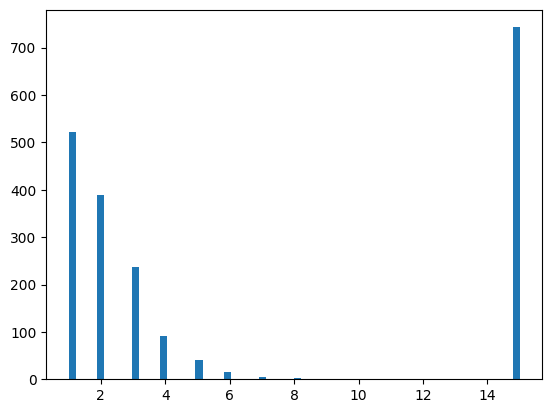

In [6]:
plt.hist(mkbatch(2048)[1].to(torch.float32).cpu(), bins=64)

(array([1516.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  420.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   94.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   16.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.]),
 array([1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
        1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
        2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
        2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375,
        3.    , 3.0625, 3.125 , 3.1875, 3.25  , 3.3125, 3.375 , 3.4375,
        3.5   , 3.5625, 3.625 , 3.6875, 3.75  , 3.8125, 3.875 , 3.9375,
        4.    , 4.0625, 4.125 , 4.1875, 4.25  , 4.3125

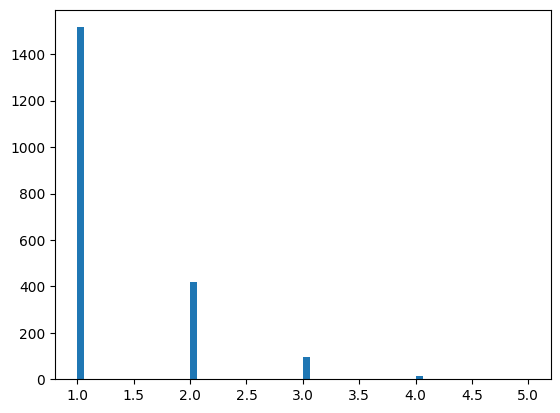

In [7]:
plt.hist(mktunebatch(2048)[1].to(torch.float32).cpu(), bins=64)

# Step 2: Define Transformer Model

In [8]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [9]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 2**15 # Batch size
NHEADS = 2
NLAYERS = 11
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*EPOCH_SIZE//10**3}K")
print(f"Trainable parameters in the model: {trainable_params}")

train_err = []
len1 = []
len2 = []
len3 = []
leninf = []
epoch = 0

# clear loss file
open('loss', 'w').close()

Training data: 1048576K
Trainable parameters in the model: 550433


In [10]:
# model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
#                          output_dim=1, num_heads=NHEADS,
#                          num_layers=NLAYERS, seq_len=SEQ_LEN,
#                          dropout=DROPOUT).to(device)
# model = torch.compile(model)
# model.load_state_dict(torch.load('model.pth', weights_only=True))

LR = 3e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Step 4: Train the Model for the first task

In [ ]:
while epoch < NEPOCHS:
    model.train()
    with open(f"data/{epoch}.pickle", "rb") as f:
        pickled_stuff = pickle.load(f)
    data = pickled_stuff["data"].to(device)
    label = pickled_stuff["labels"].to(device).to(torch.float32)
    padding = pickled_stuff["padding"].to(device)
    dataset = TensorDataset(data, label, padding)
    loader = DataLoader(dataset, batch_size=BSZ)
    for batch_src, batch_labels, batch_padding_mask in tqdm(loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        loss.backward()
        optimizer.step()
        
        train_err.append(loss.item())
        len1.append(criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels == 1]).item())
        len2.append(criterion(output[batch_labels == 2].squeeze(1), batch_labels[batch_labels == 2]).item())
        len3.append(criterion(output[batch_labels == 3].squeeze(1), batch_labels[batch_labels == 3]).item())
        leninf.append(criterion(output[batch_labels == MAX_VTXS].squeeze(1), batch_labels[batch_labels == MAX_VTXS]).item())
        
        with open('loss', 'a') as f:
            f.write(f"{train_err[-1]} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}\n")
    print(f"Epoch {epoch}/{NEPOCHS} \t Train Err: {train_err[-1]} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}")

    epoch += 1
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_weights_{epoch}.pth")

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/functional.py:6278: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  attn_output = scaled_dot_product_attention(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/tmp/torchinductor_sipb/lc/clcqc3ufbzrethiy77dmsu54kurxdmh4eji2f3msm347rhmfpf4j.py:1078: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  extern_kernels.mm(reinterpret_tensor(buf1, (524288, 64), (64, 1), 0), reinterpret_tensor(primals_5, (64, 192),

Epoch 0/1000 	 Train Err: 44.25287628173828 15.68527889251709 8.788555145263672 3.8603785037994385 100.71075439453125



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 1/1000 	 Train Err: 42.749107360839844 19.990596771240234 12.096658706665039 6.1431379318237305 90.65858459472656



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 2/1000 	 Train Err: 35.17692565917969 0.05676012113690376 15.442191123962402 8.584199905395508 82.2193374633789



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 3/1000 	 Train Err: 32.94102478027344 0.0016151332529261708 21.24653434753418 13.028000831604004 70.40452575683594



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 4/1000 	 Train Err: 30.707416534423828 0.0012646751711145043 27.01055335998535 17.616626739501953 60.88502502441406



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 5/1000 	 Train Err: 29.5562801361084 0.0010397899895906448 32.37065124511719 21.991931915283203 53.443416595458984



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 6/1000 	 Train Err: 29.092647552490234 0.0007909027044661343 36.97315979003906 25.812442779541016 47.87839126586914



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 7/1000 	 Train Err: 28.649932861328125 0.0005968677578493953 40.76370620727539 28.99480438232422 43.76168441772461



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 8/1000 	 Train Err: 28.49782943725586 0.00046271493192762136 43.50001907348633 31.30975914001465 41.015228271484375



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 9/1000 	 Train Err: 28.43338394165039 0.00036097457632422447 45.3854866027832 32.91228103637695 39.220703125



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 10/1000 	 Train Err: 28.3504581451416 0.0002947713655885309 46.44082260131836 33.81328201293945 38.23492431640625



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 11/1000 	 Train Err: 28.3637638092041 0.00025288635515607893 44.81169509887695 32.499359130859375 39.33035659790039



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 12/1000 	 Train Err: 20.932743072509766 0.020399289205670357 9.31131649017334 9.292236328125 46.657718658447266



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 13/1000 	 Train Err: 15.104679107666016 0.004516741260886192 3.496262311935425 26.43575096130371 27.609149932861328



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 14/1000 	 Train Err: 11.633755683898926 0.006426772102713585 0.33657196164131165 12.253266334533691 24.989166259765625



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 15/1000 	 Train Err: 8.730537414550781 0.005749554373323917 0.4862631857395172 14.309078216552734 15.44126033782959



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 16/1000 	 Train Err: 7.443472385406494 0.006111220922321081 0.20445628464221954 5.455012321472168 16.42494773864746



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 17/1000 	 Train Err: 5.684250354766846 0.0027684608940035105 0.17002306878566742 7.258749961853027 9.979669570922852



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 18/1000 	 Train Err: 4.853455543518066 0.002522163325920701 0.1455077826976776 5.698103427886963 8.302152633666992



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 19/1000 	 Train Err: 4.262304306030273 0.008678397163748741 0.1446814388036728 6.152136325836182 6.787021636962891



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 20/1000 	 Train Err: 3.858119487762451 0.003093192121013999 0.06649590283632278 3.3348793983459473 7.0024285316467285



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 21/1000 	 Train Err: 3.4118576049804688 0.0032999212853610516 0.08424855768680573 4.119073390960693 5.404160976409912



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 22/1000 	 Train Err: 3.108879566192627 0.0038715973496437073 0.09217671304941177 3.321317434310913 4.763245582580566



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 23/1000 	 Train Err: 2.9745163917541504 0.0034261371474713087 0.042425476014614105 2.484790802001953 5.148287296295166



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 24/1000 	 Train Err: 2.8194165229797363 0.0035489683505147696 0.04434378817677498 2.200214385986328 4.857565879821777



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 25/1000 	 Train Err: 2.570242404937744 0.0033989306539297104 0.05114512890577316 1.687565565109253 4.485219478607178



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 26/1000 	 Train Err: 2.519033432006836 0.0032220594584941864 0.037310708314180374 1.374830961227417 4.5875935554504395



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 27/1000 	 Train Err: 2.4283571243286133 0.0033829077146947384 0.05773899331688881 1.9254313707351685 3.3634419441223145



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 28/1000 	 Train Err: 2.302886962890625 0.0026804266963154078 0.03176456317305565 1.1421442031860352 4.208995819091797



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 29/1000 	 Train Err: 2.1564438343048096 0.0029864327516406775 0.05358732491731644 1.2556946277618408 3.505455255508423



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 30/1000 	 Train Err: 2.1266884803771973 0.0027816162910312414 0.0484829805791378 1.4444752931594849 2.9733316898345947



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 31/1000 	 Train Err: 2.0390195846557617 0.0022390384692698717 0.03866223618388176 1.1827622652053833 2.866259813308716



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 32/1000 	 Train Err: 1.9310557842254639 0.007157730869948864 0.04426664113998413 1.3611301183700562 2.6592557430267334



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 33/1000 	 Train Err: 1.851065754890442 0.00836748257279396 0.02673536352813244 0.9250126481056213 2.746307373046875



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 34/1000 	 Train Err: 1.8189555406570435 0.002403518883511424 0.027730008587241173 0.7969512939453125 3.080704689025879



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 35/1000 	 Train Err: 1.7624272108078003 0.0018843680154532194 0.0399935357272625 1.2561802864074707 2.1936941146850586



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 36/1000 	 Train Err: 1.6249182224273682 0.004734295420348644 0.031796831637620926 0.9225327372550964 2.0132899284362793



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 37/1000 	 Train Err: 1.567882776260376 0.0021626888774335384 0.023232363164424896 0.6002436876296997 2.547755718231201



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 38/1000 	 Train Err: 1.5313199758529663 0.00217650830745697 0.026524055749177933 0.7098141312599182 2.2419848442077637



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 39/1000 	 Train Err: 1.4404828548431396 0.004386692773550749 0.02224084362387657 0.4259363114833832 2.4182753562927246



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 40/1000 	 Train Err: 1.2733204364776611 0.0018442481523379683 0.018874434754252434 0.42629194259643555 2.229574680328369



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 41/1000 	 Train Err: 1.259386658668518 0.003313510213047266 0.029421737417578697 0.5856508612632751 1.8896589279174805



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 42/1000 	 Train Err: 1.2521576881408691 0.004783857148140669 0.01938166655600071 0.3461814820766449 2.3111233711242676



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 43/1000 	 Train Err: 1.2292133569717407 0.002071063034236431 0.021942850202322006 0.4656696617603302 2.068932056427002



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 44/1000 	 Train Err: 1.128746747970581 0.003524728585034609 0.02287750504910946 0.45642775297164917 1.7306324243545532



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 45/1000 	 Train Err: 1.0967061519622803 0.01454948354512453 0.024551132693886757 0.54127436876297 1.5558075904846191



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 46/1000 	 Train Err: 1.0431199073791504 0.012847564183175564 0.04218384996056557 0.6190078258514404 1.189369559288025



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 47/1000 	 Train Err: 1.0133185386657715 0.0021092321258038282 0.013825979083776474 0.2770753800868988 1.6761137247085571



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 48/1000 	 Train Err: 0.9567054510116577 0.004586610943078995 0.014754511415958405 0.3456564247608185 1.453568696975708



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 49/1000 	 Train Err: 0.9407138228416443 0.0070776138454675674 0.02054545097053051 0.4561208486557007 1.220456838607788



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 50/1000 	 Train Err: 0.9202176332473755 0.0031614142935723066 0.011641060933470726 0.286685585975647 1.5036773681640625



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 51/1000 	 Train Err: 0.8502955436706543 0.004485825542360544 0.014037835411727428 0.261470228433609 1.4015151262283325



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 52/1000 	 Train Err: 0.8055517673492432 0.001586323487572372 0.01207085233181715 0.25895756483078003 1.2997738122940063



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 53/1000 	 Train Err: 0.745665431022644 0.0011599217541515827 0.011456611566245556 0.3580838143825531 1.1415109634399414



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 54/1000 	 Train Err: 0.7061874866485596 0.0031232465989887714 0.011377043090760708 0.3388000428676605 0.9392197728157043



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 55/1000 	 Train Err: 0.6648885607719421 0.0012688999995589256 0.00947241485118866 0.26360955834388733 1.1422845125198364



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 56/1000 	 Train Err: 0.7076109051704407 0.0024704698007553816 0.009398349560797215 0.3038281798362732 1.1086375713348389



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 57/1000 	 Train Err: 0.6785869598388672 0.0014807500410825014 0.01062911655753851 0.2191060185432434 1.1564222574234009



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 58/1000 	 Train Err: 0.6877794861793518 0.0014096886152401567 0.009400570765137672 0.30001187324523926 1.0206444263458252



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 59/1000 	 Train Err: 0.6211211681365967 0.0020437357015907764 0.007910181768238544 0.25007426738739014 0.9663841724395752



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 60/1000 	 Train Err: 0.6470574736595154 0.002864431357011199 0.009593289345502853 0.2109789252281189 1.1501246690750122



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 61/1000 	 Train Err: 0.5603711605072021 0.0008608726784586906 0.007078849244862795 0.20478710532188416 0.8139731884002686



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 62/1000 	 Train Err: 0.578612208366394 0.0032247111666947603 0.00902671180665493 0.42988908290863037 0.7487800717353821



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 63/1000 	 Train Err: 0.5186704397201538 0.00102539814542979 0.008104916661977768 0.2222120761871338 0.7046389579772949



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 64/1000 	 Train Err: 0.5231799483299255 0.002828507451340556 0.010938749648630619 0.2966611087322235 0.7127745747566223



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 65/1000 	 Train Err: 0.47884172201156616 0.0009621918434277177 0.006440795958042145 0.18400059640407562 0.704879105091095



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 66/1000 	 Train Err: 0.5025489926338196 0.0009218254708684981 0.010015169158577919 0.31187739968299866 0.6326962113380432



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 67/1000 	 Train Err: 0.43556588888168335 0.0009745100978761911 0.004804776981472969 0.18548405170440674 0.7211376428604126



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 68/1000 	 Train Err: 0.4796810746192932 0.0011300166370347142 0.00498929712921381 0.19455471634864807 0.7402910590171814



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 69/1000 	 Train Err: 0.4702203869819641 0.0010465772356837988 0.00821524765342474 0.19802263379096985 0.6487798094749451



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 70/1000 	 Train Err: 0.4697670042514801 0.0023691540118306875 0.01255676057189703 0.12256406992673874 0.7824207544326782



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 71/1000 	 Train Err: 0.45800718665122986 0.000834575854241848 0.006560661364346743 0.31839612126350403 0.5303618311882019



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 72/1000 	 Train Err: 0.4298030138015747 0.0008242715266533196 0.004054277669638395 0.12216580659151077 0.7027520537376404



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 73/1000 	 Train Err: 0.41886794567108154 0.003492131596431136 0.006118918769061565 0.13266974687576294 0.5819666981697083



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 74/1000 	 Train Err: 0.4155438542366028 0.005384758580476046 0.004661516286432743 0.18202976882457733 0.46242862939834595



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 75/1000 	 Train Err: 0.4029538929462433 0.0027740243822336197 0.004722914192825556 0.11864388734102249 0.6423448920249939



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 76/1000 	 Train Err: 0.40730276703834534 0.0007228117901831865 0.004857086110860109 0.19555920362472534 0.5367923974990845



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 77/1000 	 Train Err: 0.36605364084243774 0.0009539870661683381 0.004075151868164539 0.07661056518554688 0.6930822730064392



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 78/1000 	 Train Err: 0.35346490144729614 0.0008490128675475717 0.011079245246946812 0.2623752951622009 0.35006481409072876



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 79/1000 	 Train Err: 0.36204081773757935 0.0009433329687453806 0.00526107894256711 0.21243207156658173 0.48520198464393616



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 80/1000 	 Train Err: 0.37033170461654663 0.007113362662494183 0.025272028520703316 0.1579497754573822 0.509062647819519



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 81/1000 	 Train Err: 0.33435767889022827 0.0053968350403010845 0.009334199130535126 0.08819041401147842 0.5340674519538879



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 82/1000 	 Train Err: 0.33757588267326355 0.0005324012017808855 0.004930454771965742 0.17805498838424683 0.5068127512931824



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 83/1000 	 Train Err: 0.31310147047042847 0.0008425716659985483 0.002387900371104479 0.0860978364944458 0.5014434456825256



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 84/1000 	 Train Err: 0.2939777672290802 0.0005211451789364219 0.0028972462750971317 0.09632651507854462 0.32632964849472046



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 85/1000 	 Train Err: 0.299526184797287 0.0010479650227352977 0.0028079829644411802 0.21169798076152802 0.40237608551979065



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 86/1000 	 Train Err: 0.30821743607521057 0.0029116582591086626 0.0035962064284831285 0.12347913533449173 0.4878503084182739



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 87/1000 	 Train Err: 0.30215075612068176 0.0008221607422456145 0.002995165530592203 0.14785777032375336 0.37114524841308594



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 88/1000 	 Train Err: 0.28064608573913574 0.0016746899345889688 0.0033167945221066475 0.12754225730895996 0.36404597759246826



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 89/1000 	 Train Err: 0.3496437072753906 0.00890024658292532 0.004831824917346239 0.15963110327720642 0.61163729429245



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 90/1000 	 Train Err: 0.25926288962364197 0.0013453153660520911 0.003530274610966444 0.1070982962846756 0.3172129690647125



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 91/1000 	 Train Err: 0.27578499913215637 0.0030208230018615723 0.0031245634891092777 0.11023195832967758 0.3903992176055908



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 92/1000 	 Train Err: 0.2994685769081116 0.004197238944470882 0.0023698117583990097 0.1903829723596573 0.4574669599533081



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 93/1000 	 Train Err: 0.2922815680503845 0.0007029320695437491 0.002348515437915921 0.05019014701247215 0.5161943435668945



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 94/1000 	 Train Err: 0.2519854009151459 0.0017584029119461775 0.002146892249584198 0.09622428566217422 0.3795848488807678



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 95/1000 	 Train Err: 0.2682843506336212 0.0005638344446197152 0.002339219441637397 0.10693421214818954 0.41891878843307495



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 96/1000 	 Train Err: 0.23551344871520996 0.0013522340450435877 0.002122987760230899 0.07678966224193573 0.39242544770240784



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 97/1000 	 Train Err: 0.22959834337234497 0.0011262426851317286 0.005589182022958994 0.09626860916614532 0.3728175759315491



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 98/1000 	 Train Err: 0.25520408153533936 0.00047998130321502686 0.0021106365602463484 0.06091078370809555 0.46852487325668335



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 99/1000 	 Train Err: 0.2501460909843445 0.0004842414637096226 0.0019760928116738796 0.08570502698421478 0.2884354889392853



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 100/1000 	 Train Err: 0.20366686582565308 0.002971487818285823 0.00713342847302556 0.11135696619749069 0.31001028418540955



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 101/1000 	 Train Err: 0.24212954938411713 0.002736428752541542 0.006694257725030184 0.07518018037080765 0.4043455421924591



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 102/1000 	 Train Err: 0.21833863854408264 0.0023800276685506105 0.0043370905332267284 0.06609099358320236 0.32194095849990845



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 103/1000 	 Train Err: 0.17334935069084167 0.0016206795116886497 0.002039699349552393 0.07832205295562744 0.2227916121482849



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 104/1000 	 Train Err: 0.22861380875110626 0.00032782970811240375 0.0014689437812194228 0.04350364953279495 0.3887456953525543



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 105/1000 	 Train Err: 0.19524142146110535 0.0035212738439440727 0.006021957378834486 0.11795622110366821 0.25324639678001404



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 106/1000 	 Train Err: 0.15101337432861328 0.0010637118248268962 0.006495238747447729 0.07132977992296219 0.20919014513492584



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 107/1000 	 Train Err: 0.16016799211502075 0.0004500410286709666 0.0017898066435009241 0.05250254645943642 0.23433028161525726



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 108/1000 	 Train Err: 0.16674524545669556 0.0010276080574840307 0.004126560874283314 0.11649245023727417 0.1926332712173462



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 109/1000 	 Train Err: 0.1631726324558258 0.000415267248172313 0.0019610195886343718 0.047292474657297134 0.2021452933549881



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 110/1000 	 Train Err: 0.15775498747825623 0.000414436828577891 0.0015739103546366096 0.09467942267656326 0.19835522770881653



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 111/1000 	 Train Err: 0.1562364548444748 0.0061783152632415295 0.0036767187993973494 0.05223577097058296 0.2691049575805664



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 112/1000 	 Train Err: 0.12982504069805145 0.006277484819293022 0.0025301864370703697 0.0412493497133255 0.1602799892425537



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 113/1000 	 Train Err: 0.16289404034614563 0.0005659068119712174 0.0012484622420743108 0.056075569242239 0.21527709066867828



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 114/1000 	 Train Err: 0.1465548872947693 0.0014426918933168054 0.0027563830371946096 0.05711502209305763 0.18701669573783875



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 115/1000 	 Train Err: 0.14275527000427246 0.000653824012260884 0.0014178442070260644 0.0954805463552475 0.21085317432880402



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 116/1000 	 Train Err: 0.15016044676303864 0.000818660540971905 0.0016999151557683945 0.06580580770969391 0.1766045093536377



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 117/1000 	 Train Err: 0.12201909720897675 0.0015263869427144527 0.0018288405844941735 0.041804831475019455 0.1663890928030014



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 118/1000 	 Train Err: 0.12489122897386551 0.00029311463003978133 0.001244824263267219 0.025852475315332413 0.14584743976593018



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 119/1000 	 Train Err: 0.13460129499435425 0.010341204702854156 0.006242326460778713 0.04511499032378197 0.2327692061662674



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 120/1000 	 Train Err: 0.1339903473854065 0.0011800267966464162 0.0022739972919225693 0.032896753400564194 0.15254607796669006



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 121/1000 	 Train Err: 0.12022703886032104 0.00038554586353711784 0.004875303246080875 0.06586042791604996 0.1974797397851944



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 122/1000 	 Train Err: 0.11403584480285645 0.0008288199896924198 0.0015265692491084337 0.02858065813779831 0.17847180366516113



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 123/1000 	 Train Err: 0.10409620404243469 0.0009630229906179011 0.0013286847388371825 0.07061317563056946 0.12211479991674423



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 124/1000 	 Train Err: 0.09401391446590424 0.0007407785742543638 0.001438300940208137 0.04962582886219025 0.11180052161216736



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 125/1000 	 Train Err: 0.11572305113077164 0.0022304926533252 0.0015191843267530203 0.044924236834049225 0.16141481697559357



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 126/1000 	 Train Err: 0.09036736190319061 0.0019903378561139107 0.000955000170506537 0.041499681770801544 0.07043104618787766



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 127/1000 	 Train Err: 0.10687348991632462 0.0012028561905026436 0.0007425333024002612 0.03638176992535591 0.15492156147956848



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 128/1000 	 Train Err: 0.10416512191295624 0.00024147499061655253 0.0009293883922509849 0.028597401455044746 0.18022169172763824



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 129/1000 	 Train Err: 0.08835020661354065 0.003051575506106019 0.003711810801178217 0.05737682431936264 0.120809406042099



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 130/1000 	 Train Err: 0.09325292706489563 0.0029582607094198465 0.0012874709209427238 0.048724617809057236 0.09893109649419785



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 131/1000 	 Train Err: 0.0896429568529129 0.00045463963760994375 0.0013198753586038947 0.035679738968610764 0.10701773315668106



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 132/1000 	 Train Err: 0.08471657335758209 0.0019452492706477642 0.0034233005717396736 0.0296705961227417 0.06480914354324341



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 133/1000 	 Train Err: 0.09226851165294647 0.0015877934638410807 0.002174847759306431 0.02515079453587532 0.13485927879810333



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 134/1000 	 Train Err: 0.08039496093988419 0.0059851668775081635 0.003604266792535782 0.023677635937929153 0.10068632662296295



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 135/1000 	 Train Err: 0.07723499834537506 0.0029561370611190796 0.0013383673503994942 0.02225509285926819 0.07217926532030106



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 136/1000 	 Train Err: 0.08774624764919281 0.0015881237341091037 0.0009627199615351856 0.03728866204619408 0.1386537104845047



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 137/1000 	 Train Err: 0.09112915396690369 0.0011313623981550336 0.000519853550940752 0.02461346611380577 0.09449820965528488



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 138/1000 	 Train Err: 0.0764939934015274 0.0015739547088742256 0.002696078270673752 0.02539546601474285 0.07497072219848633



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 139/1000 	 Train Err: 0.08085883408784866 0.0021111860405653715 0.002203426556661725 0.038074932992458344 0.09940771758556366



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 140/1000 	 Train Err: 0.06707267463207245 0.00048505759332329035 0.0005829626461490989 0.023159010335803032 0.06615001708269119



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 141/1000 	 Train Err: 0.06301475316286087 0.0009192335419356823 0.0005843854160048068 0.03602571412920952 0.0841449722647667



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 142/1000 	 Train Err: 0.06407696008682251 0.004187325481325388 0.0031896685250103474 0.025413284078240395 0.0635743960738182



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 143/1000 	 Train Err: 0.056899648159742355 0.0012612127466127276 0.0010306687327101827 0.021679643541574478 0.05377352237701416



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 144/1000 	 Train Err: 0.07650666683912277 0.00024983700131997466 0.001161872292868793 0.03564540296792984 0.08232379704713821



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 145/1000 	 Train Err: 0.05720144882798195 0.0014120059786364436 0.0017668631626293063 0.03595374524593353 0.06960506737232208



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 146/1000 	 Train Err: 0.0696098804473877 0.00025453948182985187 0.0005893263150937855 0.018764346837997437 0.03399818018078804



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 147/1000 	 Train Err: 0.06046349182724953 0.000990899046882987 0.0004648214380722493 0.02092691697180271 0.02779306285083294



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 148/1000 	 Train Err: 0.059290580451488495 0.0022199612576514482 0.001315723406150937 0.023515846580266953 0.07406013458967209



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 149/1000 	 Train Err: 0.06473296880722046 0.0018222469370812178 0.001621031784452498 0.03560686111450195 0.06342668831348419



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 150/1000 	 Train Err: 0.053641099482774734 0.0003684388066176325 0.0008896152721717954 0.026580102741718292 0.07826311886310577



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 151/1000 	 Train Err: 0.05356581509113312 7.923251541797072e-05 0.00026825847453437746 0.018474940210580826 0.06338636577129364



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 152/1000 	 Train Err: 0.053509317338466644 0.000861925829667598 0.0006878876592963934 0.03851037099957466 0.045843761414289474



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 153/1000 	 Train Err: 0.053101420402526855 9.4662478659302e-05 0.0003207987465430051 0.020021196454763412 0.06933460384607315



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 154/1000 	 Train Err: 0.04212021827697754 0.00016945773677434772 0.0002675392315723002 0.01669382117688656 0.040745120495557785



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 155/1000 	 Train Err: 0.038299448788166046 0.0006350624025799334 0.0006876391125842929 0.021383486688137054 0.03851837292313576



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 156/1000 	 Train Err: 0.05666494742035866 0.0003512321272864938 0.00041459291242063046 0.02086237445473671 0.0636894553899765



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 157/1000 	 Train Err: 0.03654496371746063 7.953925523906946e-05 0.00024021716671995819 0.016982462257146835 0.03953758254647255



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 158/1000 	 Train Err: 0.04525972530245781 0.00030174560379236937 0.00044638325925916433 0.011691144667565823 0.041540782898664474



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 159/1000 	 Train Err: 0.039281442761421204 0.0004989005392417312 0.0007457975880242884 0.02650555409491062 0.03530228137969971



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 160/1000 	 Train Err: 0.04518686234951019 0.00017189154459629208 0.00015555098070763052 0.01069786585867405 0.0570724681019783



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 161/1000 	 Train Err: 0.050255514681339264 0.00024805148132145405 0.0007079236092977226 0.02650279738008976 0.06579962372779846



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 162/1000 	 Train Err: 0.044423386454582214 0.00031116121681407094 0.0003777859383262694 0.017297720536589622 0.051457729190588



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 163/1000 	 Train Err: 0.04354090988636017 0.0005877528456039727 0.00029637134866788983 0.013659253716468811 0.020231008529663086



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 164/1000 	 Train Err: 0.031157420948147774 9.798325481824577e-05 0.0003091402177233249 0.01797928847372532 0.023115914314985275



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 165/1000 	 Train Err: 0.04593996703624725 8.030498429434374e-05 0.0002926443121396005 0.013717164285480976 0.055002935230731964



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 166/1000 	 Train Err: 0.03411879763007164 0.0003377409011591226 0.0002743960649240762 0.01241423562169075 0.01924932189285755



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 167/1000 	 Train Err: 0.04760969430208206 0.00011350985732860863 0.00043987829121761024 0.014360723085701466 0.02648620493710041



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 168/1000 	 Train Err: 0.03372378274798393 0.0002949015761259943 0.00037480168975889683 0.014883959665894508 0.016884008422493935



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 169/1000 	 Train Err: 0.03702085092663765 0.00018087019270751625 0.0006288738804869354 0.024845065549016 0.04383993148803711



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 170/1000 	 Train Err: 0.02824767678976059 0.0003424994938541204 0.0004191694315522909 0.015994146466255188 0.014700128696858883



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 171/1000 	 Train Err: 0.03430527076125145 0.0009072513785213232 0.0003185459354426712 0.015698766335844994 0.011771176941692829



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 172/1000 	 Train Err: 0.03365296125411987 0.00030303309904411435 0.00022830757370684296 0.017944660037755966 0.02212398685514927



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 173/1000 	 Train Err: 0.041653022170066833 0.000587280432227999 0.0007374075939878821 0.015334094874560833 0.06751907616853714



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 174/1000 	 Train Err: 0.03477595001459122 0.0009183208458125591 0.00013558704813476652 0.013238264247775078 0.01334806066006422



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 175/1000 	 Train Err: 0.037530943751335144 0.00025187639403156936 0.00033183913910761476 0.01504728477448225 0.031140420585870743



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 176/1000 	 Train Err: 0.027848348021507263 0.0014607060002163053 0.001157138729467988 0.011170606128871441 0.01426300685852766



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 177/1000 	 Train Err: 0.03245190531015396 0.0002554329694248736 0.00015877540863584727 0.014040789566934109 0.04714728519320488



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 178/1000 	 Train Err: 0.041977256536483765 0.0001379920431645587 0.00021775254572276026 0.009346511214971542 0.01231997087597847



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 179/1000 	 Train Err: 0.03204528987407684 9.879021672531962e-05 0.0003249702858738601 0.01157579105347395 0.032357051968574524



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 180/1000 	 Train Err: 0.030494939535856247 5.318508192431182e-05 0.0001941232185345143 0.01810402423143387 0.03970681130886078



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 181/1000 	 Train Err: 0.03218014910817146 0.0006771694752387702 0.00016017410962376744 0.009343582205474377 0.03883388638496399



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 182/1000 	 Train Err: 0.03439633548259735 8.35641985759139e-05 0.0008245277567766607 0.026584787294268608 0.04398134723305702



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 183/1000 	 Train Err: 0.03437873348593712 0.0003609458508435637 0.0001779649028321728 0.011353005655109882 0.022845609113574028



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 184/1000 	 Train Err: 0.029747625812888145 0.0005436437204480171 0.0006577487220056355 0.02241024561226368 0.03428546339273453



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 185/1000 	 Train Err: 0.03702589124441147 0.001318416208960116 0.0003100436006207019 0.006715381983667612 0.012282946147024632



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 186/1000 	 Train Err: 0.022873839363455772 0.00014723198546562344 0.0011230326490476727 0.015240584500133991 0.020318059250712395



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 187/1000 	 Train Err: 0.02688605710864067 0.00014236278366297483 0.00022871489636600018 0.017673302441835403 0.029775310307741165



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 188/1000 	 Train Err: 0.026118462905287743 3.561102130333893e-05 0.00015905339387245476 0.010189777240157127 0.01750301755964756



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 189/1000 	 Train Err: 0.031032036989927292 6.626216054428369e-05 0.0001567322324262932 0.014112681150436401 0.03739028424024582



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 190/1000 	 Train Err: 0.02181524783372879 0.00023006339324638247 0.0005933582433499396 0.010394968092441559 0.00304942368529737



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 191/1000 	 Train Err: 0.027184132486581802 0.004482210148125887 0.0019434703281149268 0.010643635876476765 0.018308935686945915



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 192/1000 	 Train Err: 0.024762475863099098 0.00021026897593401372 0.00068919628392905 0.013836676254868507 0.00759515818208456



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 193/1000 	 Train Err: 0.027485240250825882 5.092989158583805e-05 0.00041440658969804645 0.007257797755300999 0.029338931664824486



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 194/1000 	 Train Err: 0.022330544888973236 0.0004199454269837588 0.0004707501211669296 0.019549088552594185 0.0023543694987893105



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 195/1000 	 Train Err: 0.022276023402810097 6.339305400615558e-05 0.00018617554451338947 0.012746947817504406 0.02517220377922058



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 196/1000 	 Train Err: 0.02131063863635063 6.503217446152121e-05 0.0001230579655384645 0.009538630954921246 0.010168644599616528



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 197/1000 	 Train Err: 0.021132078021764755 0.0002956095850095153 8.20207133074291e-05 0.006673957221210003 0.010186844505369663



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 198/1000 	 Train Err: 0.019411560148000717 0.00042201197356916964 0.0009095012792386115 0.013239831663668156 0.018353110179305077



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 199/1000 	 Train Err: 0.03216658905148506 4.9469184887129813e-05 0.0002943709841929376 0.01148073747754097 0.016176927834749222



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 200/1000 	 Train Err: 0.02571428008377552 0.0010263347066938877 0.0005481779226101935 0.016015449538826942 0.01978922262787819



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 201/1000 	 Train Err: 0.026272011920809746 3.759583705686964e-05 9.925611811922863e-05 0.008123734965920448 0.01331140287220478



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 202/1000 	 Train Err: 0.03202397748827934 6.046362250344828e-05 0.000284630514215678 0.011763068847358227 0.04103183373808861



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 203/1000 	 Train Err: 0.012851575389504433 0.00011363952944520861 0.00016413710545748472 0.010319913737475872 0.002792573068290949



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 204/1000 	 Train Err: 0.026115499436855316 0.0005245269276201725 0.00024940649745985866 0.011106887832283974 0.02185993455350399



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 205/1000 	 Train Err: 0.018948335200548172 2.8755090170307085e-05 8.58057028381154e-05 0.005748868454247713 0.015843190252780914



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 206/1000 	 Train Err: 0.018574167042970657 0.00015149133105296642 0.00048761311336420476 0.02577385865151882 0.013325332663953304



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 207/1000 	 Train Err: 0.02082146145403385 0.000238466338487342 0.00023394331219606102 0.006748242769390345 0.019078979268670082



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 208/1000 	 Train Err: 0.014403259381651878 6.994893192313612e-05 0.0008789921994321048 0.010097990743815899 0.00996581930667162



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 209/1000 	 Train Err: 0.020921753719449043 0.0004979136865586042 0.00010895056766457856 0.00956189725548029 0.015378139913082123



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 210/1000 	 Train Err: 0.022038539871573448 0.0001340815215371549 0.00015701379743404686 0.014402204193174839 0.02424498274922371



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 211/1000 	 Train Err: 0.01667097397148609 0.00011134350643260404 0.00014891373575665057 0.00600818358361721 0.009433449245989323



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 212/1000 	 Train Err: 0.01602860540151596 4.298926069168374e-05 7.710252975812182e-05 0.004729713778942823 0.005112841725349426



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 213/1000 	 Train Err: 0.01903412863612175 0.00030714491731487215 0.0001821738842409104 0.005955686792731285 0.022314537316560745



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 214/1000 	 Train Err: 0.015248223207890987 0.00026072614127770066 0.00019891293777618557 0.007477042265236378 0.0036678414326161146



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 215/1000 	 Train Err: 0.014912809245288372 0.00047885856474749744 0.0004725187609437853 0.00442067626863718 0.006714401766657829



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 216/1000 	 Train Err: 0.022600673139095306 5.488095121108927e-05 0.0005237676086835563 0.0061714984476566315 0.03166600689291954



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 217/1000 	 Train Err: 0.022118201479315758 8.072196214925498e-05 0.00010541417577769607 0.00999145582318306 0.022547846660017967



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 218/1000 	 Train Err: 0.01601581647992134 3.067262514377944e-05 0.00018664993694983423 0.004181408789008856 0.013367431238293648



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 219/1000 	 Train Err: 0.01162786316126585 5.145326576894149e-05 0.00015623572107870132 0.006794607732445002 0.001922846888191998



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 220/1000 	 Train Err: 0.012896351516246796 0.0003044742625206709 9.53769194893539e-05 0.006998015101999044 0.003260016907006502



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 221/1000 	 Train Err: 0.023554792627692223 0.00018602493219077587 0.0004451847053132951 0.011047394014894962 0.03432558849453926



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 222/1000 	 Train Err: 0.016859270632267 0.0002703650388866663 0.00010159210069105029 0.0054770237766206264 0.013049724511802197



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 223/1000 	 Train Err: 0.018101878464221954 5.2419105486478657e-05 6.96199931553565e-05 0.005247439723461866 0.011564591899514198



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 224/1000 	 Train Err: 0.015453542582690716 0.00010983451647916809 0.00022485408408101648 0.005099967587739229 0.012966718524694443



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 225/1000 	 Train Err: 0.018901851028203964 4.1673782106954604e-05 0.0015293046599254012 0.00927029736340046 0.015386526472866535



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 226/1000 	 Train Err: 0.019163722172379494 0.0016058672918006778 0.002710553817451 0.003990732133388519 0.013572349213063717



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 227/1000 	 Train Err: 0.0185165386646986 8.810655708657578e-05 0.0001792146940715611 0.007222854066640139 0.020297806710004807



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 228/1000 	 Train Err: 0.020369376987218857 0.0009141123155131936 0.001427489914931357 0.008912032470107079 0.02442525327205658



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 229/1000 	 Train Err: 0.01552458293735981 0.00011080846888944507 6.443277379730716e-05 0.004490815103054047 0.00922235008329153



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 230/1000 	 Train Err: 0.0195521991699934 2.673462404345628e-05 0.0002968674525618553 0.0058441669680178165 0.013992007821798325



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 231/1000 	 Train Err: 0.01986689493060112 4.5369306462816894e-05 4.316281047067605e-05 0.005999550223350525 0.015800679102540016



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 232/1000 	 Train Err: 0.019927091896533966 0.00010001207556342706 0.0014023327967152 0.0054413750767707825 0.027315480634570122



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 233/1000 	 Train Err: 0.014753343537449837 0.0003090432728640735 8.334611629834399e-05 0.004138716962188482 0.004037454724311829



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 234/1000 	 Train Err: 0.012261731550097466 0.0003884017060045153 0.00043851000373251736 0.00813040230423212 0.007334974128752947



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 235/1000 	 Train Err: 0.011006608605384827 0.0003388413751963526 0.00021402201673481613 0.005710902623832226 0.008260917849838734



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 236/1000 	 Train Err: 0.00900082103908062 0.0020744148641824722 0.0004009941185358912 0.005855425260961056 0.000494154985062778


  6%|████████████▌                                                                                                                                                                                           | 2/32 [00:01<00:30,  1.00s/it]

In [16]:
# """
# Now let's figure out what it's doing. 

# step 1: figure out what people are attending to 
# """

# example_graph, answer, padding = mkbatch(1)
# sentance_embeddings = model.full_embedding(example_graph)[0,:,:][example_graph.flatten() != 0]
# WQ,WK,WV = torch.split(model.transformer_encoder.layers[0].self_attn.in_proj_weight, (MODEL_DIM, MODEL_DIM, MODEL_DIM))

# Q = sentance_embeddings@WQ
# K = sentance_embeddings@WK

# raw_scores = Q @ K.T / sqrt(MODEL_DIM)
# soft = torch.softmax(raw_scores, dim=-1).detach().cpu().to(float).numpy()
# plt.imshow(soft)
# plt.show()

# print(example_graph)

# print(Q)

In [ ]:
with open('training-loss') as f:
    train_err = list(map(float, f.read().split()))
    plt.suptitle('Log MSE vs Epochs')
    plt.plot(torch.log(torch.tensor(train_err)[:500]), label='Train', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Log MSE')
    plt.show()

plt.suptitle('Log MSE vs Epochs')
plt.plot(torch.log(torch.tensor(train_err)), label='Train', color='blue')
plt.plot(torch.log(torch.tensor(len1)).to(torch.float16), label='Len 1', color='red')
plt.plot(torch.log(torch.tensor(len2)).to(torch.float16), label='Len 2', color='green')
plt.plot(torch.log(torch.tensor(len3)).to(torch.float16), label='Len 3', color='yellow')
plt.plot(torch.log(torch.tensor(len15)).to(torch.float16), label='Len 15', color='magenta')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.legend()
plt.show()

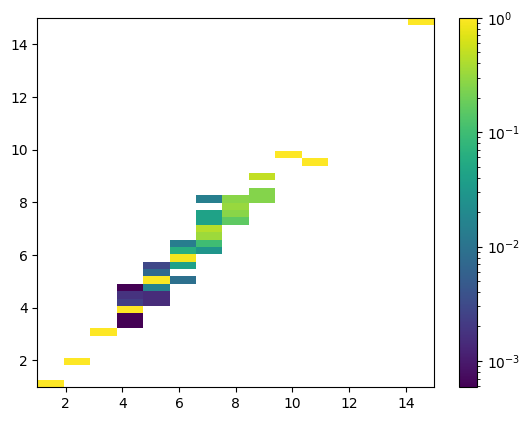

In [11]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.uint8)
y = output.detach()
cnts = torch.bincount(x)
weights = [1/cnts[i.item()].item() for i in x] # normalize by label count
fig, ax = plt.subplots()
h = ax.hist2d(x.cpu().numpy().flatten(), y.to(torch.float16).cpu().numpy().flatten(), weights=weights, bins=[15,50], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
plt.show()

In [10]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

evaluate()

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  return torch._transformer_encoder_layer_fwd(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return torch._transformer_encoder_layer_fwd(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


0.0005554668023250997

# Step 5: Fine Tune

In [11]:
N_TUNE_EPOCHS = 100
TUNE_LR = 1e-5
TUNE_WD = 0 # 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

tune_train_err = []

# clear loss file
open('tune_loss', 'w').close()

In [15]:
for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
    optimizer.zero_grad()
    output = model(batch_src, batch_padding_mask)
    loss = criterion(output.squeeze(1), batch_labels)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss}\n")
    print(f"Epoch {epoch}/{N_TUNE_EPOCHS} \t Train Err: {train_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"checkpoints/tune_model_weights_{epoch + 1}.pth")

Epoch 0/100 	 Train Err: 0.4553
Epoch 1/100 	 Train Err: 0.2545
Epoch 2/100 	 Train Err: 0.2368
Epoch 3/100 	 Train Err: 0.2138
Epoch 4/100 	 Train Err: 0.1898
Epoch 5/100 	 Train Err: 0.1931
Epoch 6/100 	 Train Err: 0.1948
Epoch 7/100 	 Train Err: 0.1847
Epoch 8/100 	 Train Err: 0.1638
Epoch 9/100 	 Train Err: 0.1490
Epoch 10/100 	 Train Err: 0.1457
Epoch 11/100 	 Train Err: 0.1509
Epoch 12/100 	 Train Err: 0.1537
Epoch 13/100 	 Train Err: 0.1472
Epoch 14/100 	 Train Err: 0.1369
Epoch 15/100 	 Train Err: 0.1304
Epoch 16/100 	 Train Err: 0.1257
Epoch 17/100 	 Train Err: 0.1201
Epoch 18/100 	 Train Err: 0.1160
Epoch 19/100 	 Train Err: 0.1064
Epoch 20/100 	 Train Err: 0.1026
Epoch 21/100 	 Train Err: 0.0964
Epoch 22/100 	 Train Err: 0.1165
Epoch 23/100 	 Train Err: 0.0990
Epoch 24/100 	 Train Err: 0.0691
Epoch 25/100 	 Train Err: 0.0633
Epoch 26/100 	 Train Err: 0.0552
Epoch 27/100 	 Train Err: 0.0505
Epoch 28/100 	 Train Err: 0.0429
Epoch 29/100 	 Train Err: 0.0376
Epoch 30/100 	 Train

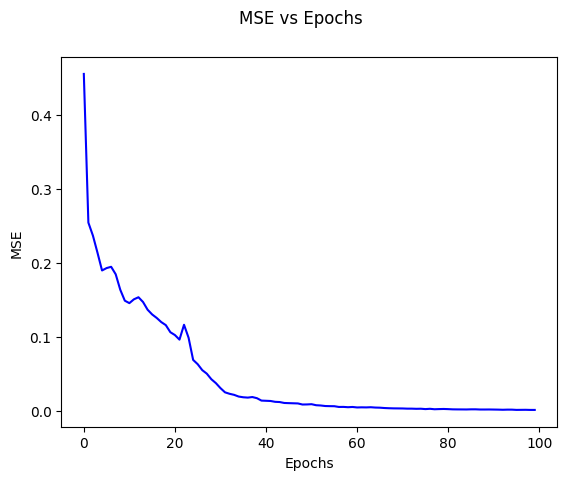

In [17]:
plt.suptitle('MSE vs Epochs')
plt.plot(tune_train_err, label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [19]:
def tune_evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

tune_evaluate()

0.001733972690999508

(array([[6.0290e+03, 1.8597e+04, 8.4000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00]]),
 array([1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  , 1.699, 1.8  ,
        1.9  , 2.   , 2.1  , 2.2  , 2.3  , 2.398, 2.5  , 2.6  , 2.7  ,
        2.8  , 2.898, 3.   , 3.1  , 3.2  , 3.299, 3.398, 3.5  , 3.6  ,
        3.7  , 3.799, 3.898, 4.   , 4.1  , 4.2  , 4.297, 4.4  , 4.5  ,
        4.6  , 4.7  , 4.797, 4.9  , 5.   , 5.098, 5.2  , 5.3  , 5.4  ,
        5.5  , 5.598, 5.7  , 5.797, 5.9  , 6.   ], dty

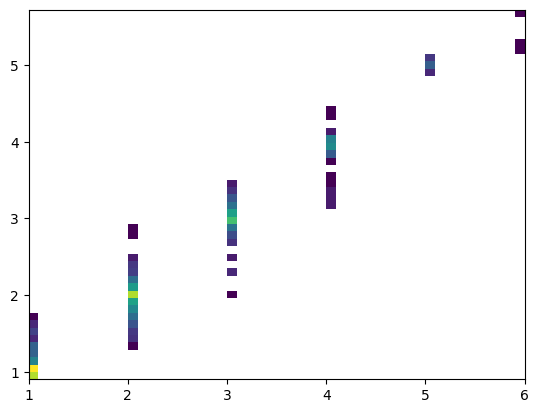

In [21]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())

# Step 6: Test generalization

0.20130713284015656


(array([[1.7789e+04, 6.5000e+02, 4.8000e+02, ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([ 1.   ,  1.18 ,  1.36 ,  1.54 ,  1.721,  1.9  ,  2.08 ,  2.262,
         2.441,  2.621,  2.8  ,  2.98 ,  3.16 ,  3.34 ,  3.521,  3.701,
         3.88 ,  4.062,  4.242,  4.42 ,  4.6  ,  4.78 ,  4.96 ,  5.14 ,
         5.32 ,  5.5  ,  5.68 ,  5.863,  6.043,  6.223,  6.402,  6.582,
         6.76 ,  6.94 ,  7.12 ,  7.3  ,  7.48 ,  7.66 ,  7.844,  8.02 ,
         8.2  ,  8.38 ,  8.56 ,  8.74 ,  8.92 ,  

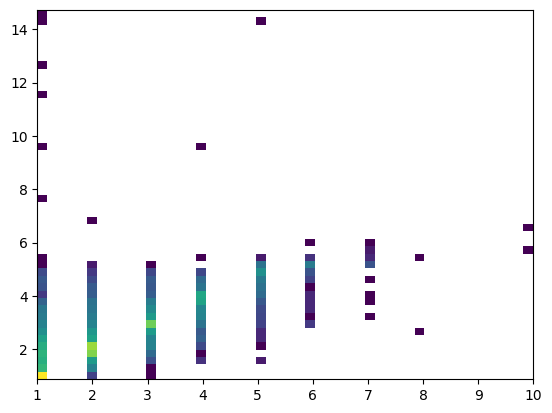

In [27]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ, test=True))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
print(criterion(output.squeeze(1), batch_labels).item())
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())